In [1]:
import pandas as pd
import demoji
from spellchecker import SpellChecker
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet,stopwords, words
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
import spacy
from spacy import displacy

In [6]:
nlp = spacy.load('en_core_web_sm')  # English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
stop_words = set(stopwords.words('english'))
words = set(nltk.corpus.words.words())
spell = SpellChecker()
table = str.maketrans('', '', string.punctuation) # table to delete the punctuation from the texts by using string library

In [7]:
collected_data = pd.read_csv('#iPhone13.csv')

In [49]:
tweets=collected_data["tweet"].values.tolist()

In [50]:
type(tweets)

list

In [10]:
def cleaning(text):
    # Replacing emojis with their describtion
    no_emoji=demoji.replace_with_desc(text," ") 
    no_at = re.sub("@[A-Za-z0-9]+","",no_emoji) #Remove @ sign
    no_link = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", no_at) #Remove http links
    no_hashtag = no_link.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    no_asci=re.sub(r'[^\x00-\x7f]',r' ',no_hashtag) #non asci
    no_punc=no_asci.translate(table) #delete punctuals

    #tweet = " ".join(w for w in nltk.wordpunct_tokenize(no_punc) # splitting the tweet into tokens
    #     if w.lower() in words and w.isalpha())
    return no_punc

In [11]:
def spell_checking(text):
    # Fixing Word Lengthening, which occurs when characters are wrongly repeated. 
    # English words have a max of two repeated characters. Additional characters need to ripped off, 
    pattern = re.compile(r"(.)\1{2,}")
    length_fixed= pattern.sub(r"\1\1", text)
    tweet = " ".join(w if (w[0].isupper()) else spell.correction(w) for w in nltk.wordpunct_tokenize(length_fixed) )
    return(tweet)

In [13]:
def nlp_analyzing(text):    
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if token.lang_ == 'en' and token.pos_ != 'SPACE' and token.text not in stop_words:
            if token.ent_type_!="":  # if the token is recognized as a Name Entity
                lemmas.append(token.text)
            elif token.text.lower() in words: #Checking if the word is in the dictionary (meaningful english world)
                lemmas.append(token.lemma_)
    return ' '.join(lemmas)


In [53]:
def clean(data):
    cleaned_data=[nlp_analyzing(spell_checking(cleaning(x))) for x in data]
    return cleaned_data
    #return data.apply(lambda x : nlp_analyzing(spell_checking(cleaning(x))))

In [51]:
tweets[0]

'Trendy Girl in Spring in Paris by DaDo ART for Galaxy S21 | ArtsCase #ArtsMakers #ArtsCase #art #phonecases #iphonecases #iphone13 #galaxys21 #apple #samsung  https://t.co/JURP0E8Tyd'

In [52]:
nlp_analyzing(spell_checking(cleaning(tweets[0])))

'Trendy Girl Spring Paris DaDo ART Galaxy art apple'

In [54]:
cleaned=clean(tweets)

In [67]:
len(cleaned)

3378

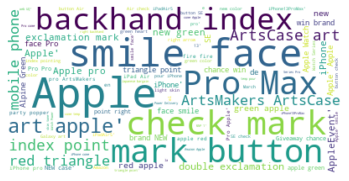

In [64]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# plotting a word cloud of positive mentions of iPhone13 in the tweets
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(cleaned))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [70]:
# writing the results to a file
with open('cleaned.txt', 'w') as f:
    for item in cleaned:
        f.write("%s\n" % item)